### setup notebook

In [21]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: rapids-0.19


### import core library

In [1]:
import sys
sys.path.append('/media/rich/Home_Linux_partition/github_repos/')

### import files

In [2]:
%load_ext autoreload
%autoreload 2
from NBAP import import_data

In [3]:
from pathlib import Path

dir_S2p             = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/suite2p/plane0')

dir_ROIClassifier   = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/analysis_lastNight')

dir_ws              = Path(r'/media/rich/bigSSD/res2p/wavesurfer data/round 5 experiments/mouse 2_6/20210417')
fileName_ws         = Path(r'exp_0001.h5')

dir_cameraCSV       = Path(r'/media/rich/bigSSD/res2p/Camera data/round 5 experiments/mouse 2_6/20210417/cam3/experiment')
fileName_cameraCSV  = Path(r'times_cam32021-04-18T00_41_02.csv')

dir_faceRhythm      = Path(r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run1/data')
fileName_faceRhythm = Path('factors_spectral_temporal_interp.npy')

In [4]:
F , Fneu , iscell , ops , spks , stat , num_frames_S2p = import_data.import_S2p(dir_S2p)

IsCell_ROIClassifier , ROI_Classifier_manual_selection_vars = import_data.import_roiClassifier(dir_ROIClassifier)

ws_data = import_data.import_ws(Path(dir_ws) / Path(fileName_ws))

cameraCSV , signal_GPIO = import_data.import_cameraCSV(Path(dir_cameraCSV) / Path(fileName_cameraCSV))

temporalFactors_faceRhythm = import_data.import_temporalFactorsFR(Path(dir_faceRhythm) / Path(fileName_faceRhythm))

### align data

In [5]:
%load_ext autoreload
%autoreload 2
from NBAP import align_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


frames in scanimage movie = 108000
frames from ws galvo extraction movie = 108000
number of wavesurfer samples per imaging frame:  33.36288888888889
Completed aligning WS to S2p. Total elapsed time: 0.18 seconds
Completed aligning Licks to S2p. Total elapsed time: 4.54 seconds
Completed aligning Rewards to S2p. Total elapsed time: 4.51 seconds
Completed aligning Treadmill to S2p. Total elapsed time: 0.45 seconds
Completed extracting camera pulses from camera data. Total elapsed time: 0.04 seconds
Completed aligning camera pulses to S2p. Total elapsed time: 0.23 seconds
Completed converting camera dates from camera data to absolute time. Total elapsed time: 0.08 seconds
Completed aligning camera frames to wavesurfer. Total elapsed time: 0.0 seconds
total elapsed time: 0.21 seconds


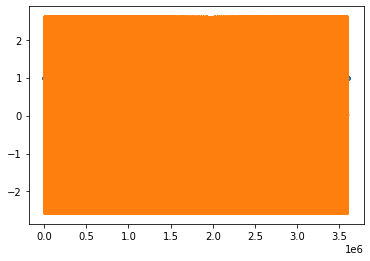

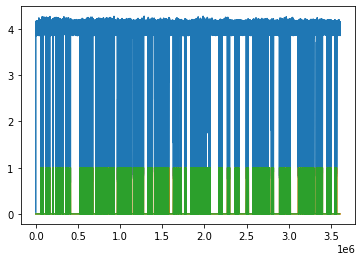

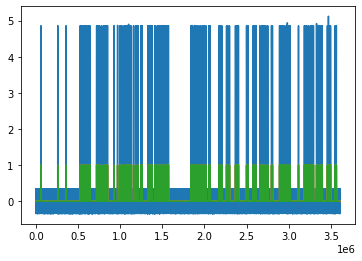

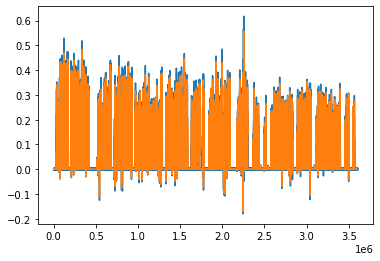

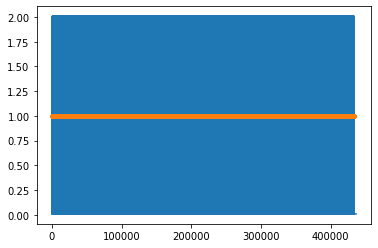

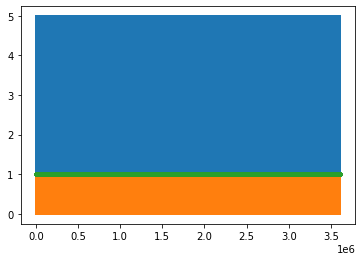

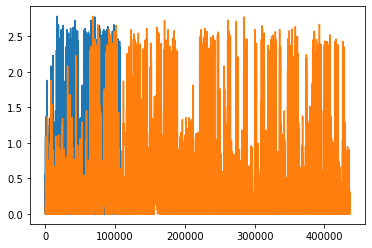

In [6]:
## == ALIGN DATA ==
%matplotlib inline

ws_galvoFlyBackTrace = ws_data[6,:] 
ws_YGalvoFlybacks_bool_wsTime , ws_frameTimes_wsTime , ws_samples_per_S2p_frame_rough = align_data.align_ws_toS2p(ws_galvoFlyBackTrace , num_frames_S2p , True)

ws_licks = ws_data[3,:]
thresh_licks = -0.2
ws_licks_bool_wsTime , ws_licks_bool_S2pInd , ws_lickTimes_S2pInd = align_data.align_licks_toS2p(ws_licks , thresh_licks , ws_frameTimes_wsTime , num_frames_S2p , True)

ws_rewards = ws_data[4,:]
thresh_rewards = 1
ws_rewards_bool_wsTime , ws_rewards_bool_S2pInd , ws_rewardTimes_S2pInd = align_data.align_rewards_toS2p(ws_rewards , thresh_rewards , ws_frameTimes_wsTime , num_frames_S2p , True)

ws_treadmill = ws_data[2,:]
ws_treadmill_S2pInd = align_data.align_treadmill_toS2p(ws_treadmill , ws_frameTimes_wsTime , num_frames_S2p , ws_samples_per_S2p_frame_rough , True)

signal_GPIO_bool_camTime , signal_GPIO_camTimes = align_data.extract_camPulses_camIdx(signal_GPIO , True)

ws_camPulses = ws_data[0,:]
ws_camSignal_bool_wsTime , ws_camSignal_wsTimes = align_data.align_ws_camPulses_toWS(ws_camPulses , True)

camTimeDates = cameraCSV[:,3]
camTimes_absolute = align_data.convert_camTimeDates_toAbsoluteSeconds(camTimeDates)

camTimes_wsInd , camTimes_wsInd_rounded , first_camPulse_camIdx , last_camPulse_camIdx = align_data.align_camFrames_toWS(signal_GPIO_camTimes , camTimes_absolute , ws_camSignal_wsTimes)

camSignal_s2pInd , first_s2pIdx_usable = align_data.align_camSignal_toS2p_andToWS(temporalFactors_faceRhythm , camTimes_wsInd , len(signal_GPIO) , ws_frameTimes_wsTime , first_camPulse_camIdx , last_camPulse_camIdx , True)

### visualize the wavesurfer data

<IPython.core.display.Javascript object>


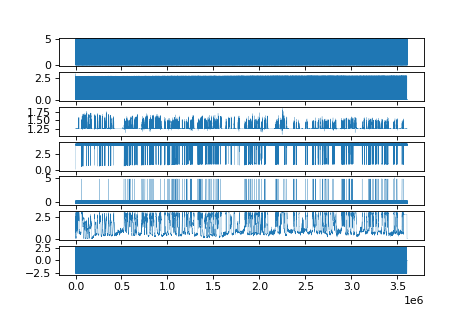

In [8]:
# show wavesurfer data
from matplotlib import pyplot as plt

%matplotlib notebook
fig , axs = plt.subplots(ws_data.shape[0] , sharex=True)
for ii in range(ws_data.shape[0]):
    axs[ii].plot(ws_data[ii,:] , linewidth=0.2)

---
---

# Saving and Loading

### Saving

In [10]:
import datetime
import numpy as np

signals_S2pAligned = {
    "ws_licks_bool_S2pInd": ws_licks_bool_S2pInd,
    "ws_rewards_bool_S2pInd": ws_rewards_bool_S2pInd,
    "ws_treadmill_S2pInd": ws_treadmill_S2pInd,
    "ws_rewards_bool_S2pInd": ws_rewards_bool_S2pInd,
    "camSignal_s2pInd": camSignal_s2pInd,
}

alignment_data = {
    "ws_YGalvoFlybacks_bool_wsTime": ws_YGalvoFlybacks_bool_wsTime,
    "ws_frameTimes_wsTime": ws_frameTimes_wsTime,
    "ws_samples_per_S2p_frame_rough": ws_samples_per_S2p_frame_rough,
    
    "thresh_licks": thresh_licks,
    "ws_licks_bool_wsTime": ws_licks_bool_wsTime,
    "ws_licks_bool_S2pInd": ws_licks_bool_S2pInd,
    "ws_lickTimes_S2pInd": ws_lickTimes_S2pInd,
    
    "thresh_rewards": thresh_rewards,
    "ws_rewards_bool_wsTime": ws_rewards_bool_wsTime,
    "ws_rewards_bool_S2pInd": ws_rewards_bool_S2pInd,
    "ws_rewardTimes_S2pInd": ws_rewardTimes_S2pInd,
    
    "ws_treadmill_S2pInd": ws_treadmill_S2pInd,
    
    "signal_GPIO_bool_camTime": signal_GPIO_bool_camTime,
    "signal_GPIO_camTimes": signal_GPIO_camTimes,
    
    "ws_camSignal_bool_wsTime": ws_camSignal_bool_wsTime,
    "ws_camSignal_wsTimes": ws_camSignal_wsTimes,
    
    "camTimes_absolute": camTimes_absolute,
    
    "camTimes_wsInd": camTimes_wsInd,
    "camTimes_wsInd_rounded": camTimes_wsInd_rounded,
    "first_camPulse_camIdx": first_camPulse_camIdx,
    "last_camPulse_camIdx": last_camPulse_camIdx,
    
    "camSignal_s2pInd": camSignal_s2pInd,
    "first_s2pIdx_usable": first_s2pIdx_usable,
    "date_now": np.array(datetime.datetime.now() , dtype='datetime64')
}

In [11]:
from pathlib import Path

dir_save = Path('/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/postHoc_analysis') 

fileName_save = 'signals_S2pAligned'
fileSuffix_save = '.npy'
path_save = dir_save / (fileName_save + fileSuffix_save)
print(f'Saving to: {path_save}')
np.save(path_save , signals_S2pAligned)

fileName_save = 'alignment_data'
fileSuffix_save = '.npy'
path_save = dir_save / (fileName_save + fileSuffix_save)
print(f'Saving to: {path_save}')
np.save(path_save , alignment_data)

Saving to: /media/rich/bigSSD/analysis_data/mouse 2_6/20210417/postHoc_analysis/signals_S2pAligned.npy
Saving to: /media/rich/bigSSD/analysis_data/mouse 2_6/20210417/postHoc_analysis/alignment_data.npy


### Loading

In [12]:
from pathlib import Path
import numpy as np

dir_load = Path('/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/postHoc_analysis')
fileName_load = 'alignment_data'
fileSuffix_load = '.npy'
path_load = dir_load / (fileName_load + fileSuffix_load)
# path_load = dir_load / fileName_load

alignment_data = np.load(path_load , allow_pickle=True)

# this line of code is reckless but useful. It imports all of the key-value pairs in a dict as variables
locals().update(alignment_data[()])